<h1>Local setup with Anaconda</h1>
<p>You will need the following packages:<p>
<ol>
    <li><b>networkx:</b> <code>conda install networkx</code></li><br>
    <li><b>hiveplot:</b> <code>conda install -c conda-forge hiveplot</code></li><br>
    <li><b>nxviz:</b> <code>conda install -c conda-forge nxviz</code></li><br>
    <li><a href="https://github.com/taynaud/python-louvain"><b>python-louvain:</b></a><code>conda install python-louvain</code></li>
<ol>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import networkx as nx
from nxviz import MatrixPlot, ArcPlot, CircosPlot
from hiveplot import HivePlot
import community 

%matplotlib inline

<h1>Loading datasets</h1>
<p>There are different file formats for storing network data and in most cases these data are divided into two files: one file contains edges and their attributes while the other contains nodes and their attributes.<br>
When loading the dataset, you have to decide which class of graphs to use based on the network structure you want to represent.
</p>
<p>
NetworkX provides the following classes:
<ul>
<li> Graph: undirected graphs with self loops </li>
<li> DiGraph: directed graphs with self loops </li>
<li> MultiGraph: undirected graphs with self loops and parallel edges </li>
<li> MultiDiGraph: directed graphs with self loops and parallel edges </li>
<li> OrderedGraphs: consistently ordered graphs </li>
</ul>
</p>
<a href="http://konect.uni-koblenz.de/networks/moreno_seventh"><h2>Seventh graders dataset</h2></a>
<p>This directed network contains proximity ratings between students from 29 seventh grade students from a school in Victoria. Among other questions the students were asked to nominate their preferred classmates for three different activities. A node represents a student. An edge between two nodes shows that the left student picked the right student as his answer. The edge weights are between 1 and 3 and show how often the left student chose the right student as his favourite.</p>

In [21]:
# Read the edge list
df = pd.read_csv('data/out.moreno_seventh_seventh', skiprows=2, header=None, sep=' ')
df.columns = ['student1', 'student2', 'count']

# Read the node metadata
nodeAttributes = pd.read_csv('data/ent.moreno_seventh_seventh.student.gender',header=None)
nodeAttributes.index += 1
nodeAttributes.columns = ['gender']
    
# Construct graph from edge list.
G = nx.DiGraph()
for row in df.iterrows():
    G.add_edge(row[1]['student1'], row[1]['student2'], count=row[1]['count'])
    
# Add node attributes
for n in G.nodes():
    (G.nodes[n])['gender'] = nodeAttributes.iloc[n-2]['gender']

print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 29
Number of edges: 376
Average in degree:  12.9655
Average out degree:  12.9655


<h3>Basic operations</h3>
<p>In the networkx implementation, graph objects store their data in dictionaries.</p>
<p>Graph.nodes -> {ID : dictionary of attributes}</p>
<p>Graph.edges -> {(ID1,ID2) : dictionary of attributes}</p>

In [22]:
#The G.nodes() returns an object of type Nodedataview
#we can cast it to a list in order to perform list-slicing and extract subsets of the graph.
#The optional parameter data lets you see nodes metadata.
list(G.nodes(data=True))[:3]

[(1, {'gender': 'female'}), (2, {'gender': 'male'}), (3, {'gender': 'male'})]

In [23]:
#count the number of nodes
len(G.nodes())

29

In [24]:
list(G.edges(data=True))[:3]

[(1, 2, {'count': 1}), (1, 3, {'count': 1}), (1, 4, {'count': 2})]

In [25]:
#access an attribute of a single node
G.nodes[1]['gender']

'female'

<p>General useful patterns are:
<ul>
    <li><code>[n2 for n1, n2, d in G.edges(data=True)]</code></li><br>
    <li><code>[d['attr'] for n, d in G.nodes(data=True)]</code></li>
</ul>
</p>

In [26]:
#wer can see how many students have "unrequited" friendships
len([(n1, n2) for n1, n2 in G.edges() if not G.has_edge(n2, n1)])

124

<h1>Graph visualization</h1>
<p>If the network is large, visualizations begin to look like <b>hairballs</b> and you can not get any useful information about its features. <br> So there are other ways to visualize networks following a <b>rational visualization approach</b>: arc plots, circus plots and hive plots. <br> The principle behind <b>rational visualization</b> is to prioritize the placement of nodes in a certain way and then look at the edges and how they are structured according to the organization of the nodes.</p>

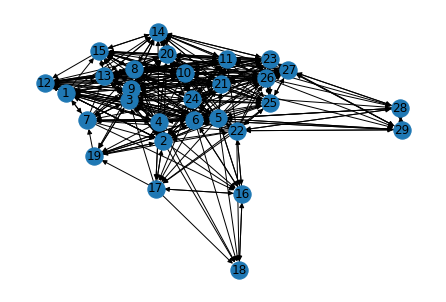

In [27]:
nx.draw(G, with_labels=True)

<a href="http://konect.uni-koblenz.de/networks/moreno_beach"><h2>Windsurfers dataset</h2></a>
<p>This undirected network contains interpersonal contacts between windsurfers in southern California during the fall of 1986.<br> A node represents a windsurfer and an edge between two windsurfers shows that there was a interpersonal contact.
</p>

In [28]:
df = pd.read_csv('data/out.moreno_train_train', skiprows=2, header=None, sep=' ')
df.columns = ['surf1', 'surf2','weight']
G = nx.from_pandas_edgelist(df, source='surf1', target='surf2',edge_attr='weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<h3>Community detection algorithms</h3>

<p>
A <b><a href="https://networkx.github.io/documentation/stable/reference/algorithms/clique.html">clique</a></b> is a complete (fully connected) subgraph, i.e. a set of vertices where each pair of vertices is connected (Cliques can overlap).<br>
A <b>maximal clique</b> is a clique that cannot be extended by including one more adjacent vertex (not included in larger one).
A <b>maximum clique</b> is a clique of the largest possible size in a given graph.
</p>
<p>
<b>Network communities</b> (cohesive subgroups) are groups of vertices such that vertices inside group connected with many more edges than beween groups.
A clique is a sort of ultimate community (maximum possible density) so the definition of a network community is a relaxation of the definition of a clique.<br>
<b>Community detection</b> is an assignment of vertices to communities (will consider non-overlapping communities: a node can belong to only one community).
<p>
We can use the <a href="https://networkx.github.io/documentation/stable/reference/generated/networkx.classes.function.density.html#networkx.classes.function.density"><b>density</b></a> measurement of a graph to see if the community found is correct.
<ol>
    <li> We measure the density of the whole graph (ρ) </li>
    <li> We measure the density of the edges outside the community (δext)</li>
    <li> Density is measured within the community (δint)</li>
</ol>    
If δint>ρ and δext<ρ then the community is correct.
</p>
<p>
The problem of identifying communities can be translated into the problem of finding the <b>optimal graph cuts</b>.<br>
By <a href="https://networkx.github.io/documentation/stable/reference/algorithms/cuts.html"><b>graph cut</b></a> we mean removing some edges in order to separate the graph into pieces. <br>
Measures can be defined to understand how many edges must be cut from the graph to identify the communities and evaluating the graph cuts (ratio cut, normalized cut, conductance).
</p>

<p>
<b><a href="https://en.wikipedia.org/wiki/Modularity_(networks)">Modularity</a></b> is one measure of the structure of networks or graphs. It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity is often used in optimization methods for detecting community structure in networks. It compare fraction of edges within the cluster to expected random graph with identical degree sequence.
The idea is if you split the graph into communities how much denser the part that is supposed to be a community compared to a random graph.
</p>

<p>
<b><a href="https://networkx.github.io/documentation/stable/reference/algorithms/community.html">Community detection algorithms</a></b> are greedy or heuristics algorithms and in general there are two approaches to finding communities: multiway partitioning (by looking at the graph you'are trying to cut out community areas) and recoursive partitioning.<br>
Some community detection algorithms are basically optimization algorithms of some measure (density, cut graph, modularity).
</p>

<p>Listed below are some community detection algorithms.<br>
<b>Edge betweenness algorithm (Newman-Girven, 2004):</b> greedy algorithm with a focus on edges that connect communities<br>
<b>Spectral modularity partition (Newman, 2004) - Leading eigenvector:</b> algorithm with a focus on modularity maximization<br>
<b>Label propagation algorithm (U.N. Raghavan, R. Albert, S. Kamura, 2007):</b> it's an heuristic algorithm<br>
<b>Fast community unfolding algorithm:</b> heuristic method for greedy modularity optimization that follows the louvain method. This method is not based on the graph cut but starts with the nodes assigned to a certain cluster and
change the cluster of a node only if it increases modularity. This algorithm is currently one of the most used because it is very efficient and scalable. <br>
<b>Walktrap community:</b> it is about combining nodes together and not about cutting the graph and it is based on the concept on the random walk. The idea is that if a path starts from a node within a community, the path will remain there for a long time before going out
<p>
   

<p>In this case we use <b>python-louvain</b> for undirected graphs. The algorithm divides the nodes into groups and then we add this information to each node.</p>

In [29]:
partition = community.best_partition(G)
for n in G.nodes():
    G.nodes[n]['group'] =  partition[n]

<h2>Arc plot</h2>
<p>In arc diagrams, nodes are displayed along a single axis and links are represented with arcs.<br>Nodes can be grouped or ordered by a criteria in order to visualize the <b>density</b> of the connections between groups.</p>

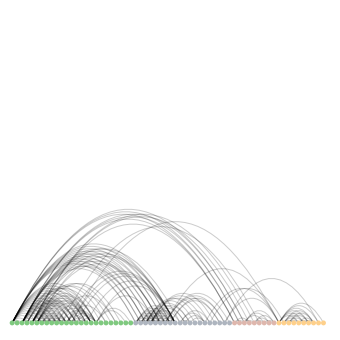

In [30]:
a = ArcPlot(G, node_color='group', node_grouping='group', node_labels=True)
a.draw()

<h2>Circos plot</h2>
<p>This visualization helps us highlight nodes that there are <b>poorly connected</b>, and others that are <b>strongly connected</b>.</p>

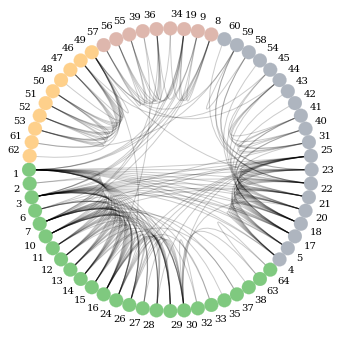

In [32]:
c = CircosPlot(G, node_color='group', node_grouping='group', node_labels=True)
c.draw()

<h2>Hiveplots</h2>
<p>Hive plots allow us to divide our nodes into sub-groups, and visualize the within- and between-group connectivity.</p>

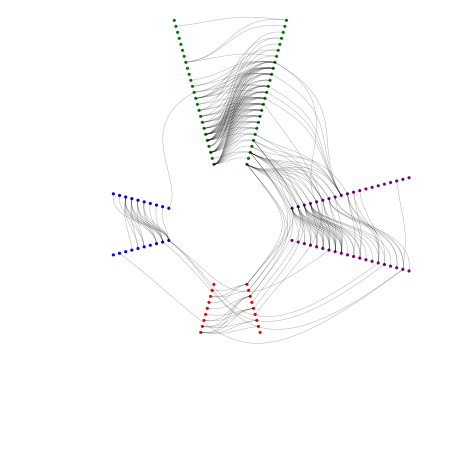

In [33]:
colors=['green','purple','red','blue','orange','yellow']
groups=list(pd.Series(partition).unique())

nodes = dict()
nodes_cmap = dict()
for i in groups:
    nodes[i] = [n for n,d in G.nodes(data=True) if d['group'] == i]
    nodes_cmap[i] = colors[i]

edges = dict()
edges['group1'] = G.edges(data=True)

edges_cmap = dict()
edges_cmap['group1'] = 'black'

h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<p>We can get a better visualization using only three groups for example, we could choose the three groups that have more edges than the others.</p>

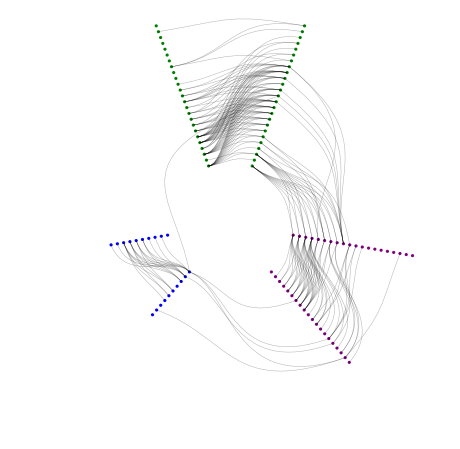

In [34]:
groups=list(pd.Series(partition).value_counts()[:3].index)
nodes = dict()
nodes_cmap = dict()
for i in groups:
    nodes[i] = [n for n,d in G.nodes(data=True) if d['group'] == i]
    nodes_cmap[i] = colors[i]

edges = dict()
edges['group1'] = G.subgraph([n for n in G.nodes() if (G.nodes()[n]['group'] in groups)]).edges(data=True)

h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<h1>Centrality measures</h1>

<p>The centrality measures are used to identify and classify the most important nodes in the network.<br>Some of the applications are finding the most influential people in a social network or identifying the super spreaders of a disease.</p>

<a href="http://konect.uni-koblenz.de/networks/moreno_train"><h2>Train bombing dataset</h2></a>
<p>This undirected network contains contacts between suspected terrorists involved in the train bombing of Madrid on March 11, 2004 as reconstructed from newspapers. A node represents a terrorist and an edge between two terrorists shows that there was a contact between the two terroists. The edge weights denote how 'strong' a connection was. This includes friendship and co-participating in training camps or previous attacks.</p>

In [35]:
df = pd.read_csv('data/out.moreno_train_train', skiprows=2, header=None, sep=' ')
df.columns = ['terrorist1', 'terrorist2','weight']
G = nx.from_pandas_edgelist(df, source='terrorist1', target='terrorist2',edge_attr='weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<p>We can see with the following visualization which are the most influential and active terrorists.</p>

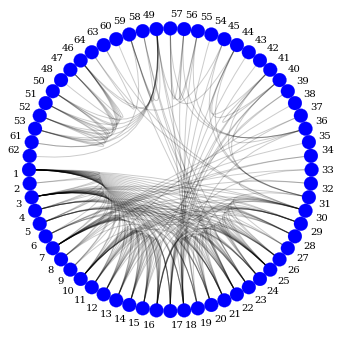

In [36]:
c = CircosPlot(G, node_labels=True)
c.draw()

In [16]:
sorted(G.nodes(),key=lambda x:len(list(G.neighbors(x))), reverse=True)[0:5]

[1, 3, 7, 10, 25]

In [18]:
sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

[(1, 0.4603174603174603),
 (3, 0.42857142857142855),
 (7, 0.3492063492063492),
 (10, 0.2857142857142857),
 (25, 0.2698412698412698)]

In [19]:
sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:5]

[(1, 0.5833333333333334),
 (3, 0.5727272727272728),
 (25, 0.5080645161290323),
 (7, 0.5),
 (22, 0.49606299212598426)]

<b><i>The hearth of a graph lies in its edges, not in its nodes</i></b><br>
<i>- John Quackenbush Harvard School of Public Health</i>